# An introduction to decision trees

## 1. Game of Thrones example

### 1.1 Generate and pre-process the data

In the following code block, we generate a data set with just one variable, "age", to mimick our "Game of Thrones" tree example. 

In [217]:
import random
import pandas as pd

#This code is provided 
random.seed(123)
age_0 = pd.DataFrame([19])
age_1 = pd.DataFrame(sorted(random.sample(range(18, 50), 20)))
age_2 = pd.DataFrame(sorted(random.sample(range(35, 70), 20)))
age_3 = pd.DataFrame([68])

age = age_0.append(age_1, ignore_index= True)
age = age.append(age_2, ignore_index= True)
age = age.append(age_3, ignore_index= True)


label_1 = pd.DataFrame([1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
label_2 = pd.DataFrame([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0])


label = label_1.append(label_2, ignore_index=True)
data = pd.concat([age, label], axis=1)

data.columns = ['age', 'label']

This data is created in such a way that the data is not perfectly separable, and also in a way that younger people seem to be more likely to watch the show.

In [218]:
data.head()

,age,label
0,19,1
1,19,0
2,20,1
3,21,0
4,22,1


In [219]:
data.tail()

,age,label
37,64,0
38,65,1
39,67,0
40,68,1
41,68,0


### 1.2  Manually create a split

We'll try to manually calculate what the "perfect split" is for this data set, so we'll basically try to recreate the first "split" in the decision tree from our lab. Let's show it again:

![title](G_of_T_tree.png)

Is 41 the best split? Let's find out! You'll create 3 functions in total:
- A function `split()` which splits up the data set in a way that you can easily compute the gini for the two "children" of the parent node, given a split value.
- A function `gini_score()`, which, given a certain split, computes the gini for the left node, the gini for the right node, and the purity gain
- A function `best_split()` which loops over the former two functions to find the best split. 

Let's start by creating the `split()` function. This function takes three arguments, the first one is the column name, which should be a string, the second one is the value that represents the split (in this example, representing a certain age), and as a third argument the name of the data set.

In [229]:
def split(col_name, value, data):
    #split the data in 2 given a column name and the value
    data_left = data.loc[data[col_name] <= value]
    data_right = data.loc[data[col_name] > value]
    return data_left, data_right

Let's use our newly created function on the column "age" (for this data the only option), and look at the age 44.

In [230]:
data_left, data_right = split("age", 44, data)

In [231]:
data_left

,age,label
0,19,1
1,19,0
2,20,1
3,21,0
4,22,1
5,23,1
6,26,1
7,28,1
8,29,1
9,30,1


In [232]:
data_right

,age,label
18,46,1
19,48,1
20,49,1
27,45,0
28,47,0
29,49,0
30,50,0
31,53,0
32,54,0
33,59,0


In [233]:
def gini_score(data_left, data_right):
    
    # amount of instances flowing in the left vs right node
    size_left= len(data_left)
    size_right = len(data_right)
    n_samples = size_left + size_right
    
    # respective chances of seeing each outcome in the left vs right node 
    p_0L = (data_left['label']==0).sum() / size_left
    p_1L = (data_left['label'] == 1).sum() / size_left
    p_0R = (data_right['label'] == 0).sum() / size_right
    p_1R = (data_right['label'] == 1).sum() / size_right
    
    #take the squares and sum over each node
    score_L = p_0L*p_0L+p_1L*p_1L
    score_R = p_0R*p_0R+p_1R*p_1R
    
    # left node and right node ginis
    gini_L = 1- score_L
    gini_R = 1- score_R
    
    #weighted ginis
    weight_gini_L = gini_L * (size_left / n_samples)
    weight_gini_R = gini_R * (size_right / n_samples)
    
    # The gains (here, we don't compute the root gini again. This value should be mimimized.)
    gain = weight_gini_L + weight_gini_R
    return gini_L, gini_R, gain

In [234]:
gini_score(data_left, data_right)

(0.4444444444444444, 0.4012345679012346, 0.42592592592592593)

In [235]:
def best_split(data, col_name):
    # make sure you have the correct range to loop over
    min_val = data[col_name].min()
    max_val = data[col_name].max()
    best_score = 999
    # loop over all the ages 
    for i in range(min_val, max_val):
        data_left, data_right = split(col_name, i, data)
        gini_l, gini_r, gain = gini_score(data_left, data_right)
        # update if gain is lower than any previously observed gain 
        if gain < best_score:
            best_val = i
            best_score = gain
            best_groups = data_left, data_right
            best_ginis= gini_l, gini_r
    output = {}
    # create a dictionary with the best value, the best gain, the best groups and the best ginis
    output['val'] = best_val 
    output['gain'] = best_score
    output['groups'] = best_groups  
    output['ginis'] = best_ginis

    return output

In [236]:
best_output = best_split(data, "age")
best_output['ginis']
split_age = best_output['val']

split_age

49

In [237]:
# If you want to see what's going on in each loop...
#min_age=19
#max_age=68
#for i in range(min_age, max_age):
#        data_left, data_right = split("age", i, data)
#        data_l,data_r, gini = gini_score(data_left, data_right)
#        print(i)   
#        print(gini)

### 1.3 Use scikit learn and verify answer

We'll use scikit-learn to create a decision tree. 

In [244]:
from sklearn import tree

In [245]:
clf_GoT = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 1)

Now we can use `clf.fit` with "age" as a first argument and "label" as a second argument. If you only have 1 predictor, you need to reshape your predictor using `.reshape(-1, 1)`. 

In [246]:
GoT_tree = clf_GoT.fit(data['age'].reshape(-1, 1), data['label'])

/Users/anneleendirick/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [248]:
GoT_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [251]:
import graphviz 
from sklearn.tree import export_graphviz
GoT_graph = tree.export_graphviz(GoT_tree, out_file=None) 
graph = graphviz.Source(GoT_graph)

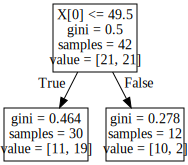

In [254]:
export_graphviz(GoT_tree, out_file="mytree.dot")
with open("mytree.dot") as f: dot_graph = f.read()
graphviz.Source(dot_graph)

We see that scikit learn generated the same split! Now, let's verify if we computed the correct gini measures. 

## 2. US salaries data set

### 2.1 Data pre-processing

The salary data set was extracted from the census bureau database and contains salary information. The goal is to use this data set and to try to draw conclusions regarding what drives salaries. More specifically, the target variable is categorical (> 50k; <= 50 k)

In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
salaries = pd.read_csv("salaries_final.csv", index_col = 0)

In [4]:
salaries.tail()

,Age,Education,Occupation,Relationship,Race,Sex,Target
32556,27,Assoc-acdm,Tech-support,Wife,White,Female,<=50K
32557,40,HS-grad,Machine-op-inspct,Husband,White,Male,>50K
32558,58,HS-grad,Adm-clerical,Unmarried,White,Female,<=50K
32559,22,HS-grad,Adm-clerical,Own-child,White,Male,<=50K
32560,52,HS-grad,Exec-managerial,Wife,White,Female,>50K


The dataset "salaries" contains 6 predictors, and one outcome variable, the target salary <= 50k/ >50k.

The 6 predictors are:
- `Age`: continuous.

- `Education`: Categorical. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, 
Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

- `Occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

- `Relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

- `Race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

- `Sex`: Female, Male.

It's important to know that scikit learn needs to get dummies as an input for categorical variables. Luckily, we can use the `dmatrices` from the patsy library to get our data in the correct shape. From our 7 predictors, we only have 2 continuous variables ("Age" and "Education-Num"). The other 5 are all categorical.

In [5]:
from patsy import dmatrices
target, data = dmatrices('Target ~ Age + C(Education) + \
                  C(Occupation) + C(Relationship) + C(Race) + C(Sex)',
                  salaries, return_type = "dataframe")

Make a train and test split

In [6]:
data_train, data_test,target_train, target_test = train_test_split(data, target, 
                                                                   test_size = 0.25, random_state=123)

### 2.2 Creating trees

In [9]:
from sklearn import tree
import graphviz 
from sklearn.tree import export_graphviz
sal_tree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 12)
sal_tree = sal_tree.fit(data_train, target_train.iloc[:,1])

export_graphviz(sal_tree, out_file="mytree.dot", feature_names=data_train.columns , class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [17]:
from sklearn import tree
sal_tree_smaller = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
sal_tree_smaller = sal_tree_smaller.fit(data_train, target_train.iloc[:,1])

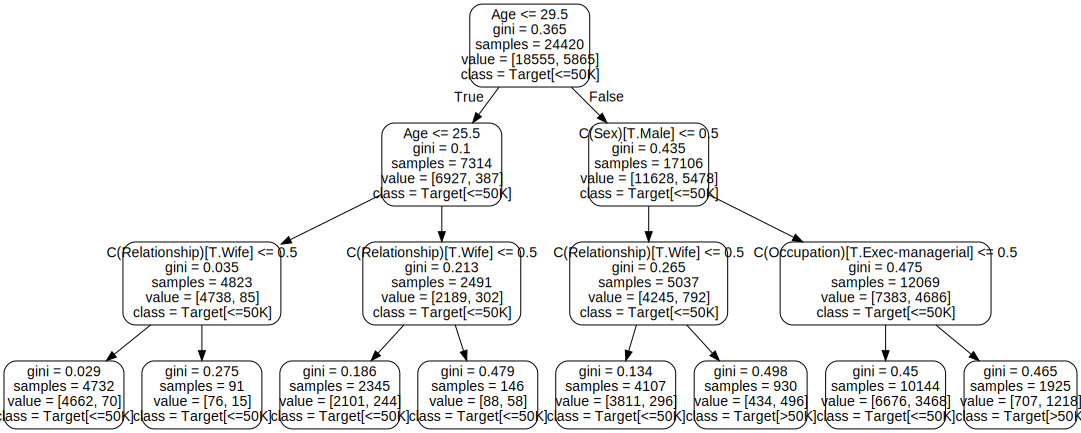

In [18]:
export_graphviz(sal_tree_smaller, out_file="mytree.dot", feature_names=data_train.columns ,
                class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Most leaf nodes will point to <= 50 k. How is this possible?
--> imbalance! 5865 make more than 50k <-> 18555 make less (~25-75%)

Note how the left nodes always point to "true" and the right nodes to "false".

### 2.3 Model performance

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
pred= sal_tree.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred))
print(metrics.classification_report(target_test.iloc[:,1], pred))

[[5590  575]
 [ 911 1065]]
             precision    recall  f1-score   support

        0.0       0.86      0.91      0.88      6165
        1.0       0.65      0.54      0.59      1976

avg / total       0.81      0.82      0.81      8141



In [21]:
accuracy_score(target_test.iloc[:,1], pred)

0.8174671416287925

In [22]:
pred_smaller = sal_tree_smaller.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred_smaller))
print(metrics.classification_report(target_test.iloc[:,1], pred_smaller))

[[5766  399]
 [1417  559]]
             precision    recall  f1-score   support

        0.0       0.80      0.94      0.86      6165
        1.0       0.58      0.28      0.38      1976

avg / total       0.75      0.78      0.75      8141



In [23]:
accuracy_score(target_test.iloc[:,1], pred_smaller)

0.776931580886869

### pre-tuning

- criterion: either gini for gini impurity, or entropy for information gain.
- max_depth: the maximum depth of a tree.
- min_samples_split: minimum amount of samples required to split an internal node.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- class_weight: Weights associated with classes.

In [24]:
from sklearn import tree
sal_tree_tuned= tree.DecisionTreeClassifier(criterion = "gini",
                                            max_depth = 12, min_samples_split = 300, min_samples_leaf = 150)
sal_tree_tuned = sal_tree_tuned.fit(data_train, target_train.iloc[:,1])

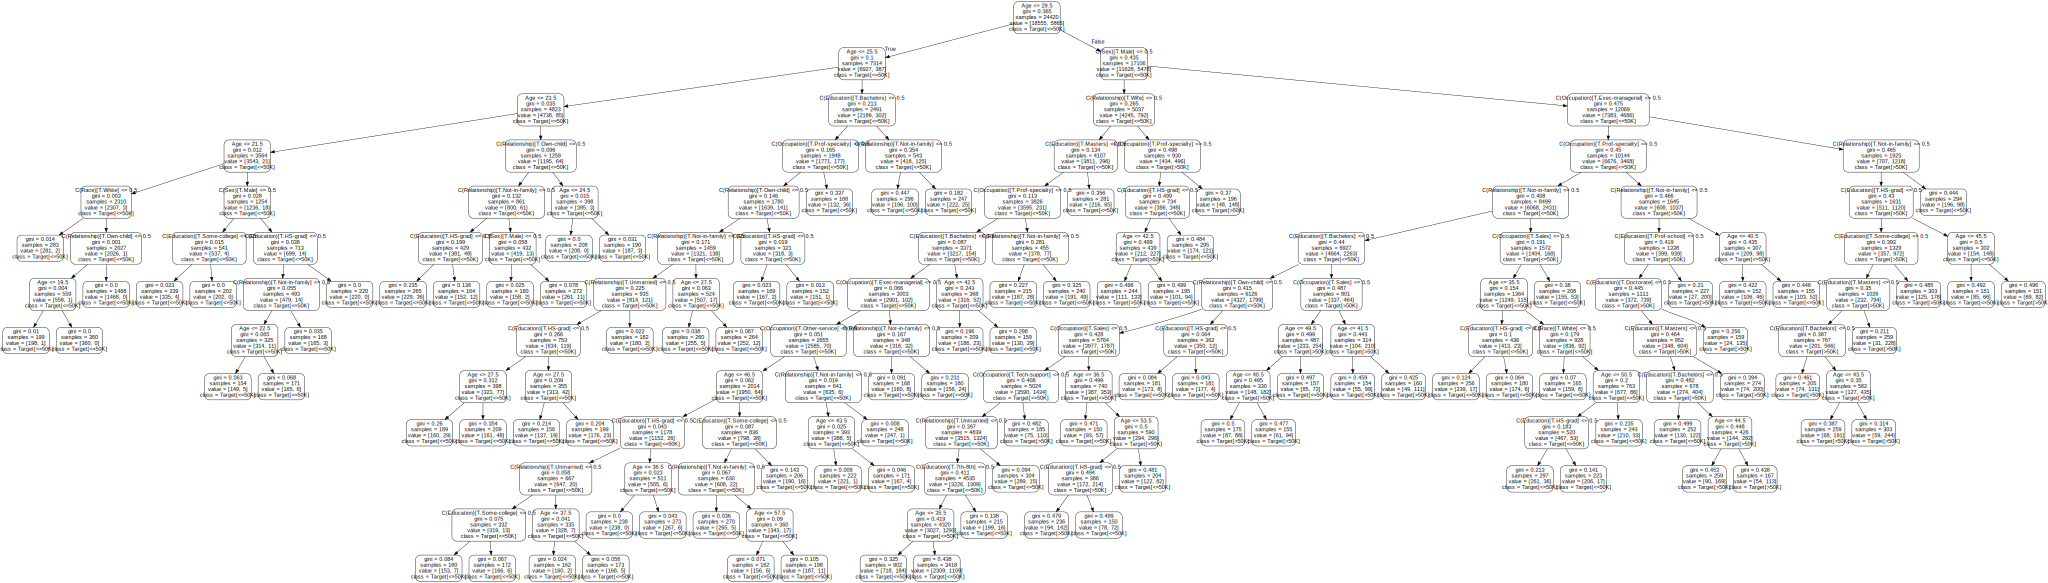

In [25]:
export_graphviz(sal_tree_tuned, out_file="mytree.dot", feature_names=data_train.columns , 
                class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [26]:
pred_tuned = sal_tree_tuned.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred_tuned))
print(metrics.classification_report(target_test.iloc[:,1], pred_tuned))

accuracy_score(target_test.iloc[:,1], pred_tuned)

[[5731  434]
 [1037  939]]
             precision    recall  f1-score   support

        0.0       0.85      0.93      0.89      6165
        1.0       0.68      0.48      0.56      1976

avg / total       0.81      0.82      0.81      8141



0.8193096671170618

For this deep tree: better result with pruning!

# Sources
https://www.svds.com/machine-learning-vs-statistics/ 

https://github.com/xbno/Projects/blob/master/Models_Scratch/Decision%20Trees%20from%20scratch.ipynb

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

http://scikit-learn.org/stable/modules/tree.html